In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import networkx as nx
from copy import deepcopy

Use the same grid as in Astar problem. Assume there is no graph available. Use RRT/ RRT* to sample paths, build a graph and find the shortest path

Make a gif of the path evolution




First, import everything

In [2]:
!tree ./data ./figures

./data
├── astar_grid.npy
├── brc202d.png
└── brc204d.png
./figures
├── astar.png
├── djikstra.png
├── graph.png
└── map_route.png

0 directories, 7 files


In [3]:
# Import the astat_grid.npy
grid = np.load("./data/astar_grid.npy")
# Choose a start and goal (index base 1)
start = (1, 1)
goal = (1, 19)
# For adding a boundary (peripery)
#  Top and Bottom
grid = np.vstack((
    np.ones((1, grid.shape[1])),
    grid,
    np.ones((1, grid.shape[1]))
))
#  Left and right
grid = np.hstack((
    np.ones((grid.shape[0], 1)),
    grid,
    np.ones((grid.shape[0], 1))
))

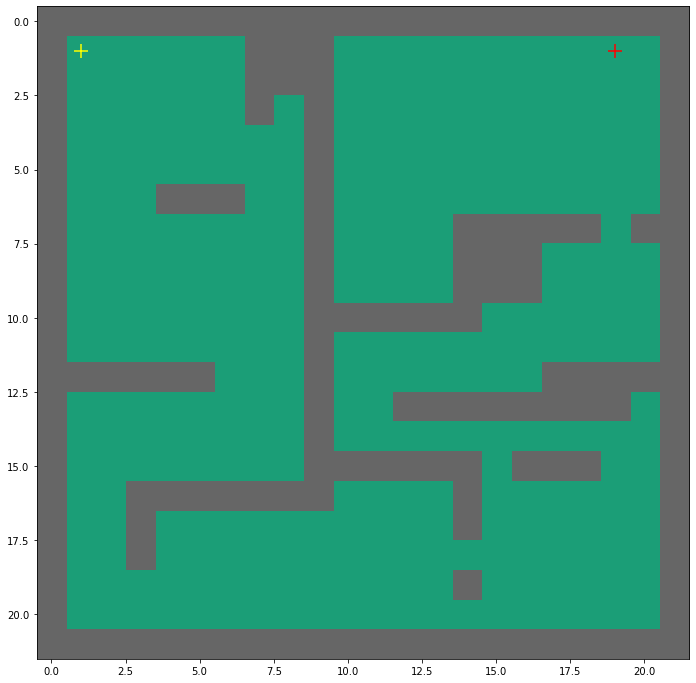

In [4]:
# Visualize everything
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
plt.show()

## Implementing RRT

The [RRT Algorithm](https://en.wikipedia.org/wiki/Rapidly-exploring_random_tree#Algorithm) involves implementing the following

1. Generate a random node in the free configuration space
2. Given an existing graph, find the nearest node in the graph that is closest to the generated random node
3. Create a new node in the direction of the random node, with a distance $\Delta q$ from the nearest node. For simplicity, $\Delta q = 1$ here.

In [5]:
# Euclidean function for distance measurements
def euclidean(node1, node2):
  x1, y1 = node1
  x2, y2 = node2
  return ((x2-x1)**2+(y2-y1)**2)**(0.5)

In [6]:
# Generate random node in the grid's free space
#   enodes is a list of already existing nodes in the graph
def gen_random_node(grid):
  x_range, y_range = grid.shape
  # Generate random points till new one in free space
  in_free_space = False
  cx, cy = (0, 0)
  while not in_free_space:
    # Generate random point
    cx = np.random.randint(0, x_range)
    cy = np.random.randint(0, y_range)
    if grid[cx, cy] == 0:
      in_free_space = True
  return (cx, cy)

In [7]:
# Given a node (x, y), find the node in its neighborhood closest to goal
#   Returns xres, yres, min_eudist
def get_closest_neighbor(node, goal, grid):
  x_n, y_n = node
  min_eudist = np.inf
  xres = x_n
  yres = y_n
  for x in [x_n - 1, x_n, x_n + 1]:
    for y in [y_n - 1, y_n, y_n + 1]:
      if (x, y) == (x_n, y_n) or grid[x, y] != 0:
        continue  # Same or occupied not to be searched
      dist = euclidean((x, y), goal)
      if dist < min_eudist:
        # Found a new nearest neighbor
        min_eudist = dist
        xres = x
        yres = y
  return xres, yres, min_eudist

In [8]:
# Get the node in graph that is closest to the random node
#   The dq value is assumed to be 1
#   Return the neighbor, min_node
def get_closest_node(grid, graph, rand_node):
  # Iterate over all nodes in the graph and get the node with minimum eu-dist
  min_eudist = np.inf
  min_node = (0, 0)
  for node in list(nx.dfs_tree(graph)):
    dist = euclidean(node, rand_node)
    if dist < min_eudist:
      min_eudist = dist
      min_node = node
  # Now that we have `min_node`, attach a neighbor to it
  nbx, nby, nb_dist = get_closest_neighbor(min_node, rand_node, grid)
  return (nbx, nby), min_node

Main RRT code

In [9]:
# Create a graph with the starting node
G = nx.Graph()  # Graph
G.add_node(start)
_grid = deepcopy(grid)  # We'll use _grid in this cell
_grid[start] = 0.5 # Traversed start (set traversed value to 0.5)
path = None # No path yet
# Run till the goal is in graph and path to start exists
while not nx.is_simple_path(G, [start, goal]):
  # Get a random node in free space (neither already in graph nor in occupied space)
  (xr, yr) = gen_random_node(_grid)
  # Get nearest node's neighbor, add node at dq to the graph and return the graph
  nb, min_node = get_closest_node(_grid, G, (xr, yr))
  # print(f"Min: {min_node}, NB: {nb}")
  G.add_edge(min_node, nb)
  _grid[nb] = 0.5 # New node in grid
  if np.sum(_grid) == 0.5 * 323 + 161:
    path = nx.shortest_path(G, start, goal)
    break

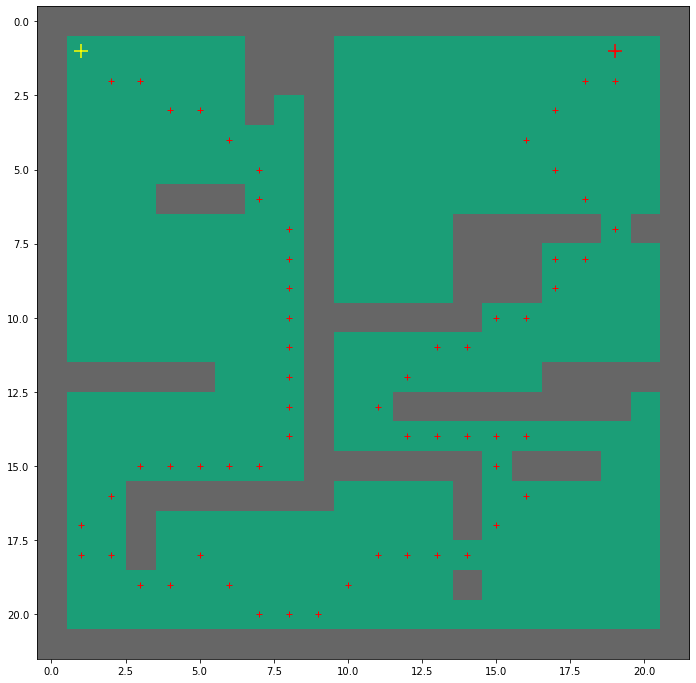

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in path[1:]:
  ax.plot(s[1], s[0],'r+')


This is not dijkstra, the graph was created using the logic of RRT. Notice the path is not smooth. Run it multiple times and you'll get a different path each time (because it's random)